# Notebook: Analysis of HMM Regression Surrogate Pipeline
**Objective:**  
1. Load pre-computed black-box observation sequences.
2. Train the full `HMMRegressionSurrogate` pipeline: 
   a. Fit the HMM component. 
   b. Extract features using HMM outputs. 
   c. Fit regression models (for next-step probability and prediction intervals). 
3. Analyze the HMM component (states, transitions) - similar to the basic HMM notebook. 
4. Analyze the Regression component (validation metrics, feature importance). 
5. Visualize predictions on test reviews, showing: 
   a. True black-box probabilities. 
   b. Decoded HMM states. 
   c. Regression model's prediction for P(TARGET_SENTIMENT) at the next step. 
   d. Prediction intervals from the regression model."

In [1]:
import sys  
import os  
import numpy as np  
import matplotlib.pyplot as plt  
import pickle  
  
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)  
  
from src.config import (  
    LOG_FILE_PATH, TARGET_SENTIMENT,   
    NUM_TEST_SAMPLES, MAX_TOKENS, MODEL_NAME, DEVICE,   
    NUM_HMM_STATES, HMM_N_ITER, HMM_TOL, HMM_COV_TYPE,   
    PROB_THRESHOLDS  
)  
from src.data_utils import load_imdb_data, preprocess_data_for_inference_logging  
from src.black_box_model import BlackBoxSentimentClassifier   , log_inference_trajectories
from src.hmm_classification_surrogate import HMMRegressionSurrogate  
from src.visualization_utils import plot_hmm_transition_matrix, plot_avg_probabilities_per_state 
  
%matplotlib inline  
  
PIPELINE_MODEL_SAVE_PREFIX = "models/hmm_reg_pipeline_imdb_noobs" 

/home/gamerio/miniconda3/envs/playground/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
try:  
    loaded_data = np.load(LOG_FILE_PATH)  
    all_observation_sequences = [loaded_data[f'arr_{i}'] for i in range(len(loaded_data.files))]  
    print(f"Loaded {len(all_observation_sequences)} total observation trajectories from {LOG_FILE_PATH}.")  
    if all_observation_sequences:  
        print(f"Example trajectory 0 shape: {all_observation_sequences[0].shape}")  
except FileNotFoundError:  
    print(f"Error: Log file {LOG_FILE_PATH} not found. Please run Notebook 01_Inference_Logging.ipynb first.")  
    all_observation_sequences = []


Loaded 25000 total observation trajectories from /home/gamerio/Documents/pml/PMLproject/notebooks/data/imbd_inference_logs25k.npz.
Example trajectory 0 shape: (512, 2)


In [3]:
pipeline_surrogate = None  
TRAIN_PIPELINE = False 
  
if TRAIN_PIPELINE:  
    if all_observation_sequences and len(all_observation_sequences) > 50: 
        pipeline_surrogate = HMMRegressionSurrogate(  
            n_states=NUM_HMM_STATES,   
            n_iter=HMM_N_ITER, 
            tol=HMM_TOL,  
            covariance_type=HMM_COV_TYPE, 
            random_state=2,  
            regression_method='mlp',   
            min_hmm_covar=1e-3,   
            
            use_feature_scaling=True,  
            use_pca_features=False, 
            n_pca_components=3 
        )  
          
        # The train_full_pipeline method handles HMM training, feature extraction,   
        # regression training, and internal validation splits for regression.  
        # It uses a split of `all_observation_sequences` for HMM training vs. regression data generation.  
        pipeline_surrogate.train_full_pipeline(  
            all_observation_sequences,   
            validation_split_ratio=0.25, # 25% of total for regression data generation + reg validation  
            regression_train_split_ratio=0.8 # Within the 25%, 80% for reg training, 20% for reg validation  
        )  
  
        pipeline_surrogate.save_pipeline(PIPELINE_MODEL_SAVE_PREFIX)  
    else:  
        print("Skipping pipeline training: not enough observation sequences loaded or TRAIN_PIPELINE is False.")  
else:  
    print(f"Attempting to load pre-trained pipeline from prefix {PIPELINE_MODEL_SAVE_PREFIX}")  
    try:  
        pipeline_surrogate = HMMRegressionSurrogate.load_pipeline(PIPELINE_MODEL_SAVE_PREFIX)  
        if not pipeline_surrogate.is_hmm_trained or not pipeline_surrogate.is_regression_trained:  
            print("Loaded pipeline is not fully trained. Check saved model.")  
            pipeline_surrogate = None  
    except FileNotFoundError:  
        print(f"Error: Pre-trained pipeline not found at {PIPELINE_MODEL_SAVE_PREFIX}.pkl. Please train one first.")  
        pipeline_surrogate = None

Attempting to load pre-trained pipeline from prefix models/hmm_reg_pipeline_imdb_noobs
Full HMM Regression Pipeline loaded from models/hmm_reg_pipeline_imdb_noobs.pkl


--- Analyzing HMM Component from Pipeline ---

--- HMM State Analysis (Threshold-Based Naming) ---
State 0: Occurrences = 2163051, Avg. P(Class 1) = 0.013
State 1: Occurrences = 2198067, Avg. P(Class 1) = 0.983
State 2: Occurrences = 2521468, Avg. P(Class 1) = 0.507

Suggested HMM State Interpretations (based on P(Class 1)):
  HMM State 0: ~Leaning Negative/Low Confidence (Avg. P(Class 1) = 0.013)
  HMM State 2: ~Neutral/Uncertain (Avg. P(Class 1) = 0.507)
  HMM State 1: ~Leaning Positive/High Confidence (Avg. P(Class 1) = 0.983)


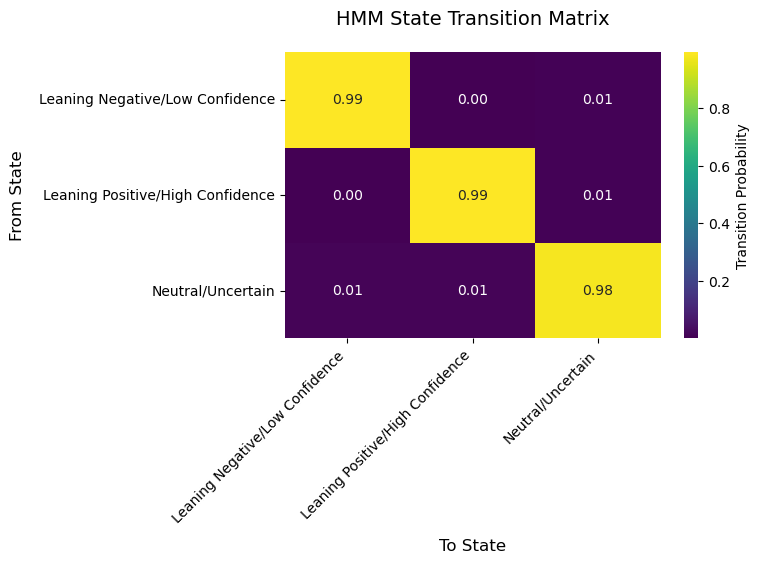

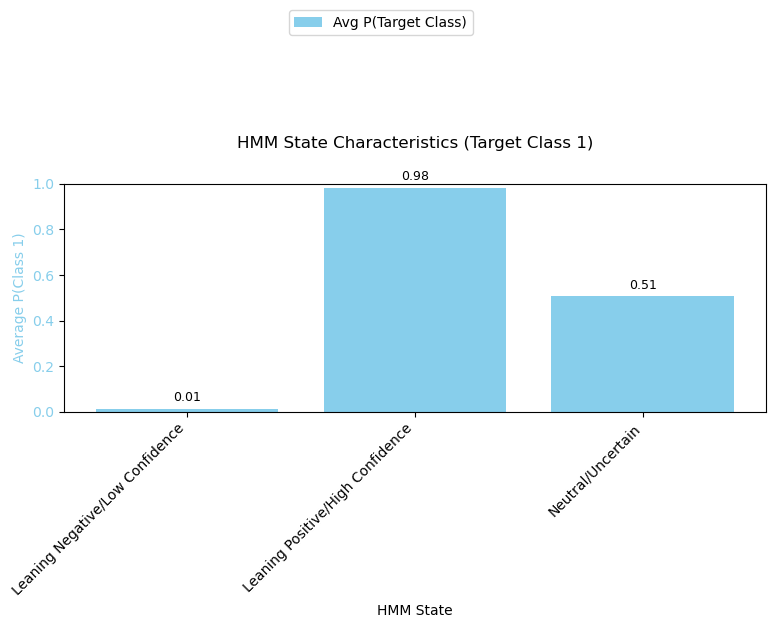

In [4]:
hmm_state_analysis_results_pipeline = None  
if pipeline_surrogate and pipeline_surrogate.is_hmm_trained:  
    print("--- Analyzing HMM Component from Pipeline ---")  
    
  
    analysis_sequences = all_observation_sequences[: len(all_observation_sequences)] 
      
    decoded_hmm_states_for_analysis = [  
        pipeline_surrogate.decode_hmm_sequence(traj)   
        for traj in analysis_sequences if traj.shape[0] > 0  
    ]  
      
    valid_obs_for_analysis = [  
        traj for traj, states in zip(analysis_sequences, decoded_hmm_states_for_analysis) if states.size > 0  
    ]  
    valid_decoded_states_for_analysis = [states for states in decoded_hmm_states_for_analysis if states.size > 0]  
  
    if valid_obs_for_analysis and valid_decoded_states_for_analysis:  
        hmm_state_analysis_results_pipeline = pipeline_surrogate.analyze_hmm_states(  
            valid_obs_for_analysis,   
            valid_decoded_states_for_analysis,   
            target_class_idx=TARGET_SENTIMENT  
        )  
      
        if hasattr(pipeline_surrogate, 'hmm_model'):   
             plot_hmm_transition_matrix(pipeline_surrogate.hmm_model, state_names=hmm_state_analysis_results_pipeline.get('state_names'))  
             plot_avg_probabilities_per_state(hmm_state_analysis_results_pipeline, target_class_idx=TARGET_SENTIMENT)  
    else:  
        print("Could not perform HMM state analysis due to lack of valid data for analysis")  
else:  
    print("Pipeline or HMM component not trained/loaded. Skipping HMM state analysis.")

In [ ]:
# if pipeline_surrogate and pipeline_surrogate.is_hmm_trained and pipeline_surrogate.is_regression_trained and hmm_state_analysis_results_pipeline:  
#     print("--- Visualizing Pipeline Predictions on Test Reviews ---")  
      
#     bb_model_vis = BlackBoxSentimentClassifier(model_name=MODEL_NAME, device=DEVICE)  
#     tokenizer_vis = bb_model_vis.tokenizer  
  
#     imdb_test_raw_vis = load_imdb_data(split='test', num_samples=NUM_TEST_SAMPLES, shuffle=True)  
#     processed_test_data_vis = preprocess_data_for_inference_logging(imdb_test_raw_vis, tokenizer_vis)  
#     test_trajectories_bb_truth = log_inference_trajectories(processed_test_data_vis, bb_model_vis, max_len=MAX_TOKENS)  
      
#     test_tokens_list_vis = []  
#     for item in processed_test_data_vis:  
#         cls_token_id = tokenizer_vis.cls_token_id  
#         actual_tokens = item['tokens']  
#         if cls_token_id is not None and item['input_ids'][0] == cls_token_id: 
#             pass  
#         elif cls_token_id is not None: 
#             actual_tokens = [tokenizer_vis.cls_token] + item['tokens']  
#         test_tokens_list_vis.append(actual_tokens[:MAX_TOKENS])  
  
# #     from src.visualization_utils import plot_state_timeline_from_surrogate
    
# #     for i, (true_bb_prob_traj, tokens_for_plot) in enumerate(zip(test_trajectories_bb_truth, test_tokens_list_vis)):  
# #         if true_bb_prob_traj.shape[0] < 1: 
# #             continue  
  
# #         print(f"\nVisualizing Test Sample {i+1} (length {len(tokens_for_plot)}):")  
# #         print(f"Text: {processed_test_data_vis[i]['text'][:150]}...")  
        
        
# #         current_tokens = tokens_for_plot[:len(true_bb_prob_traj)]

# #         try:
# #             # Call the wrapper function
# #             plot_state_timeline_from_surrogate(
# #                 hmm_surrogate=pipeline_surrogate,
# #                 tokens=current_tokens,           
# #                 prob_trajectory=true_bb_prob_traj, 
# #                 target_class_idx=TARGET_SENTIMENT, 
# #                 show_predictions=True            
# #             )
# #         except Exception as e:
# #             print(f"  Error plotting sample {i+1}: {e}")
# #             import traceback
# #             traceback.print_exc() 
# #             continue
        
# #         if i >= 14: 
# #             print(f"\nShowing first {i+1} samples. Set this limit higher to see more.")
# #             break
            
# # else:  
# #     print("Pipeline components not fully trained/loaded or HMM state analysis missing. Skipping final test visualizations.")

# Train MLP for early sentiment classification

In [ ]:
from datasets import load_dataset

if pipeline_surrogate and pipeline_surrogate.is_hmm_trained:
   
    bb_model_vis = BlackBoxSentimentClassifier(model_name=MODEL_NAME, device=DEVICE)  
    tokenizer_vis = bb_model_vis.tokenizer  
   
    unbalanced_test_data= load_dataset("imdb", split='test')
    unbalanced_test_data = unbalanced_test_data.shuffle(seed = 3)
    
    
   
    unbalanced_test_data = unbalanced_test_data.filter(lambda x: len(x['text']) > 200*6)
    
    
    
    positive_samples = []
    negative_samples = []
    num_samples_per_class = 250

    for sample in unbalanced_test_data:
        
        if sample['label'] == 1 and len(positive_samples) < num_samples_per_class:
            positive_samples.append(sample)
        elif sample['label'] == 0 and len(negative_samples) < num_samples_per_class:
            negative_samples.append(sample)
        
        if len(positive_samples) == num_samples_per_class and len(negative_samples) == num_samples_per_class:
            break
            
    if len(positive_samples) < num_samples_per_class or len(negative_samples) < num_samples_per_class:
        raise ValueError(f"Could not find enough samples for a balanced test set. "
                         f"Found {len(positive_samples)} positive and {len(negative_samples)} negative samples.")

    imdb_test_raw_vis = positive_samples + negative_samples
    import random
    random.seed(2)
    random.shuffle(imdb_test_raw_vis)
    
    print(f" Successfully created a balanced test set with {len(positive_samples)} positive and {len(negative_samples)} negative reviews.")
   
    
    processed_test_data_vis = preprocess_data_for_inference_logging(imdb_test_raw_vis, tokenizer_vis)  
    test_trajectories_bb_truth = log_inference_trajectories(processed_test_data_vis, bb_model_vis, max_len=MAX_TOKENS)
   
    
    final_positive_count = sum(1 for traj in test_trajectories_bb_truth if traj[-1, TARGET_SENTIMENT] >= 0.5)
    final_negative_count = len(test_trajectories_bb_truth) - final_positive_count
    print(f" Verified balance: {final_positive_count} positive, {final_negative_count} negative based on transformer final predictions")
    
    
    K_PREFIX_VALUES = [1,5,10,25,50,75,100,150,175,200]  
    BEST_K_PREFIX = 25 

    
    prefix_results = {}

    print(f"\n Testing different prefix lengths: {K_PREFIX_VALUES}")
    print(f" Training on {len(all_observation_sequences)} observation sequences")
    print(f" Testing on {len(test_trajectories_bb_truth)} test trajectories")

    for k_prefix in K_PREFIX_VALUES:
        print(f"\n{'='*50}")
        print(f"TESTING PREFIX LENGTH: {k_prefix}")
        print(f"{'='*50}")
        
    
        temp_success = pipeline_surrogate.train_final_sentiment_classifier(
            all_observation_sequences, 
            k_prefix=k_prefix
        )
        
        if temp_success:
            print(f" Successfully trained classifier with k_prefix={k_prefix}")
          
            correct_predictions = 0
            total_predictions = 0
            prediction_confidence_scores = []
            skipped_sequences = 0
       
            for seq in test_trajectories_bb_truth:
                if seq.shape[0] >= k_prefix:
                    try:
                        prefix = seq[:k_prefix]
                        
                        true_final_prob = seq[-1, pipeline_surrogate.target_sentiment_idx]
                        true_label = 1 if true_final_prob >= 0.5 else 0
                        
                       
                        pred_label, pred_proba = pipeline_surrogate.predict_final_sentiment_from_prefix(prefix)
                        
                        if pred_label == true_label:
                            correct_predictions += 1
                        
                       
                        confidence = pred_proba[pred_label]   #probability of predicted class
                        prediction_confidence_scores.append(confidence)
                        
                        total_predictions += 1
                        
                    except Exception as e:
                        continue
                else:
                    skipped_sequences += 1
            
            if total_predictions > 0:
                accuracy = correct_predictions / total_predictions
                avg_confidence = np.mean(prediction_confidence_scores)
                
                prefix_results[k_prefix] = {
                    'accuracy': accuracy,
                    'avg_confidence': avg_confidence,
                    'total_predictions': total_predictions,
                    'skipped_sequences': skipped_sequences
                }
                
                print(f" Test Set Evaluation Results:")
                print(f"   • Accuracy: {accuracy:.3f} ({correct_predictions}/{total_predictions})")
                print(f"   • Average Confidence: {avg_confidence:.3f}")
                print(f"   • Skipped {skipped_sequences} sequences that were shorter than {k_prefix} tokens")
                
                if k_prefix == K_PREFIX_VALUES[0] or accuracy > prefix_results[BEST_K_PREFIX]['accuracy']:
                    BEST_K_PREFIX = k_prefix
                    print(f" New best prefix length: {BEST_K_PREFIX}")
            else:
                print(f" No valid predictions made with k_prefix={k_prefix}")
        else:
            print(f" Failed to train classifier with k_prefix={k_prefix}")

 

    final_success = pipeline_surrogate.train_final_sentiment_classifier(
        all_observation_sequences, 
        k_prefix=BEST_K_PREFIX
    )

    if final_success:
        print(f"Final sentiment classifier trained successfully!")
        
       
        
       
        
     
        print(f"\n PREFIX LENGTH COMPARISON (TEST SET PERFORMANCE):")
        print(f"{'Prefix Length':<15} {'Accuracy':<10} {'Confidence':<12} {'Predictions':<12} {'Skipped':<12}")
        print("-" * 65)
        
        for k, results in prefix_results.items():
            print(f"{k:<15} {results['accuracy']:<10.3f} {results['avg_confidence']:<12.3f} {results['total_predictions']:<12} {results['skipped_sequences']:<12}")
        
        print(f"\n EXAMPLE TEST PREDICTIONS WITH PREFIX LENGTH {BEST_K_PREFIX}:")
        print("-" * 60)
        
        example_count = 0
        positive_examples = 0
        negative_examples = 0
        
        for i, seq in enumerate(test_trajectories_bb_truth[:20]):  
            if seq.shape[0] >= BEST_K_PREFIX and example_count < 8:
                try:
                   
                    prefix = seq[:BEST_K_PREFIX]
                    true_final_prob = seq[-1, pipeline_surrogate.target_sentiment_idx]
                    true_label = 1 if true_final_prob >= 0.5 else 0
                    
                    
                    pred_label, pred_proba = pipeline_surrogate.predict_final_sentiment_from_prefix(prefix)
                    
                 
                    if (true_label == 1 and positive_examples < 4) or (true_label == 0 and negative_examples < 4):
                        print(f"\nTest Example {example_count + 1} (Sequence {i}):")
                        print(f"   Sequence Length: {seq.shape[0]} tokens")
                        print(f"   Review Text: {processed_test_data_vis[i]['text'][:100]}...")
                        print(f"   True Final Sentiment: {'POSITIVE' if true_label == 1 else 'NEGATIVE'} (prob={true_final_prob:.3f})")
                        print(f"   Predicted from Prefix: {'POSITIVE' if pred_label == 1 else 'NEGATIVE'}")
                        print(f"   Prediction Probabilities: [Neg: {pred_proba[0]:.3f}, Pos: {pred_proba[1]:.3f}]")
                        print(f"   Correct: {'YES' if pred_label == true_label else 'NO'}")
                        
                        prefix_target_probs = prefix[:, pipeline_surrogate.target_sentiment_idx]
                        print(f"   Prefix Target Sentiment Evolution: {[f'{p:.3f}' for p in prefix_target_probs]}")
                        
                        example_count += 1
                        if true_label == 1:
                            positive_examples += 1
                        else:
                            negative_examples += 1
                            
                except Exception as e:
                    continue
        
    
    
        
       
        
        
        all_true_labels = []
        all_pred_labels = []
        all_pred_probas = []
        sequence_lengths = []
        confidence_by_correctness = {'correct': [], 'incorrect': []}
        
        for seq in test_trajectories_bb_truth:
            if seq.shape[0] >= BEST_K_PREFIX:
                try:
                    prefix = seq[:BEST_K_PREFIX]
                    true_final_prob = seq[-1, pipeline_surrogate.target_sentiment_idx]
                    true_label = 1 if true_final_prob >= 0.5 else 0
                    
                    pred_label, pred_proba = pipeline_surrogate.predict_final_sentiment_from_prefix(prefix)
                    
                    all_true_labels.append(true_label)
                    all_pred_labels.append(pred_label)
                    all_pred_probas.append(pred_proba[1])  # Probability of positive class
                    sequence_lengths.append(seq.shape[0])
                    
            
                    confidence = pred_proba[pred_label]
                    if pred_label == true_label:
                        confidence_by_correctness['correct'].append(confidence)
                    else:
                        confidence_by_correctness['incorrect'].append(confidence)
                        
                except Exception:
                    continue
        
        if all_true_labels:
            from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
            
            accuracy = accuracy_score(all_true_labels, all_pred_labels)
            precision = precision_score(all_true_labels, all_pred_labels, zero_division=0)
            recall = recall_score(all_true_labels, all_pred_labels, zero_division=0)
            f1 = f1_score(all_true_labels, all_pred_labels, zero_division=0)
            
            print(f" Test Set Classification Metrics (n={len(all_true_labels)}):")
            print(f"   • Accuracy:  {accuracy:.3f}")
            print(f"   • Precision: {precision:.3f}")
            print(f"   • Recall:    {recall:.3f}")
            print(f"   • F1-Score:  {f1:.3f}")
     
            cm = confusion_matrix(all_true_labels, all_pred_labels)
            print(f"\n Confusion Matrix:")
            print(f"   Predicted:  Neg  Pos")
            print(f"   True Neg:   {cm[0,0]:<4} {cm[0,1]:<4}")
            print(f"   True Pos:   {cm[1,0]:<4} {cm[1,1]:<4}")
            
            
            if confidence_by_correctness['correct'] and confidence_by_correctness['incorrect']:
                avg_conf_correct = np.mean(confidence_by_correctness['correct'])
                avg_conf_incorrect = np.mean(confidence_by_correctness['incorrect'])
                
                print(f"\n Confidence Analysis:")
                print(f"   • Avg confidence (correct predictions):   {avg_conf_correct:.3f}")
                print(f"   • Avg confidence (incorrect predictions): {avg_conf_incorrect:.3f}")
                print(f"   • Confidence gap: {avg_conf_correct - avg_conf_incorrect:.3f}")
            
            
            avg_seq_length = np.mean(sequence_lengths)
            print(f"\n Sequence Length Analysis:")
            print(f"   • Average test sequence length: {avg_seq_length:.1f} tokens")
            print(f"   • Prefix covers: {(BEST_K_PREFIX/avg_seq_length)*100:.1f}% of average sequence")
            
       
            positive_ratio = np.mean(all_true_labels)
            print(f"\n Test Set Class Distribution:")
            print(f"   • Positive samples: {np.sum(all_true_labels)}/{len(all_true_labels)} ({positive_ratio:.1%})")
            print(f"   • Negative samples: {len(all_true_labels) - np.sum(all_true_labels)}/{len(all_true_labels)} ({1-positive_ratio:.1%})")
        
        print(f"\n{'='*60}")
        print(" FINAL SENTIMENT CLASSIFICATION ANALYSIS COMPLETE")
        print(f" Best prefix length: {BEST_K_PREFIX} tokens")
        print(f" Evaluated on {len(test_trajectories_bb_truth)} test reviews")
        print(f" Ready for early sentiment prediction!")
        print(f"{'='*60}")

    else:
        print(" Failed to train final sentiment classifier")
        
else:
    print(" Pipeline surrogate not available or HMM not trained. Skipping final sentiment classification analysis.")

Model loaded successfully on cuda
loaded black box model: lvwerra/distilbert-imdb
Labels: {0: 'NEGATIVE', 1: 'POSITIVE'}
 Successfully created a balanced test set with 250 positive and 250 negative reviews.


Processing data: 100%|██████████| 500/500 [23:03<00:00,  2.77s/it]


 Verified balance: 254 positive, 246 negative based on transformer final predictions

 Testing different prefix lengths: [1, 5, 10, 25, 50, 75, 100, 150, 175, 200]
 Training on 25000 observation sequences
 Testing on 500 test trajectories

TESTING PREFIX LENGTH: 1

Training final sentiment classifier based on 1-token prefixes...


Extracting final prediction features from prefixes: 100%|██████████| 25000/25000 [00:11<00:00, 2264.77it/s]


Extracted 25000 feature vectors for final classification.
Fitting final sentiment classifier...
Validation Accuracy of final sentiment classifier: 0.5002
Final sentiment classifier training complete.
 Successfully trained classifier with k_prefix=1
 Test Set Evaluation Results:
   • Accuracy: 0.508 (254/500)
   • Average Confidence: 0.504
   • Skipped 0 sequences that were shorter than 1 tokens
 New best prefix length: 1

TESTING PREFIX LENGTH: 5

Training final sentiment classifier based on 5-token prefixes...


Extracting final prediction features from prefixes: 100%|██████████| 25000/25000 [00:11<00:00, 2233.78it/s]


Extracted 25000 feature vectors for final classification.
Fitting final sentiment classifier...
Validation Accuracy of final sentiment classifier: 0.5636
Final sentiment classifier training complete.
 Successfully trained classifier with k_prefix=5
 Test Set Evaluation Results:
   • Accuracy: 0.520 (260/500)
   • Average Confidence: 0.561
   • Skipped 0 sequences that were shorter than 5 tokens
 New best prefix length: 5

TESTING PREFIX LENGTH: 10

Training final sentiment classifier based on 10-token prefixes...


Extracting final prediction features from prefixes: 100%|██████████| 25000/25000 [00:11<00:00, 2232.94it/s]


Extracted 25000 feature vectors for final classification.
Fitting final sentiment classifier...
Validation Accuracy of final sentiment classifier: 0.6270
Final sentiment classifier training complete.
 Successfully trained classifier with k_prefix=10
 Test Set Evaluation Results:
   • Accuracy: 0.562 (281/500)
   • Average Confidence: 0.584
   • Skipped 0 sequences that were shorter than 10 tokens
 New best prefix length: 10

TESTING PREFIX LENGTH: 25

Training final sentiment classifier based on 25-token prefixes...


Extracting final prediction features from prefixes: 100%|██████████| 25000/25000 [00:11<00:00, 2179.51it/s]


Extracted 24992 feature vectors for final classification.
Fitting final sentiment classifier...
Validation Accuracy of final sentiment classifier: 0.7171
Final sentiment classifier training complete.
 Successfully trained classifier with k_prefix=25
 Test Set Evaluation Results:
   • Accuracy: 0.614 (307/500)
   • Average Confidence: 0.656
   • Skipped 0 sequences that were shorter than 25 tokens
 New best prefix length: 25

TESTING PREFIX LENGTH: 50

Training final sentiment classifier based on 50-token prefixes...


Extracting final prediction features from prefixes: 100%|██████████| 25000/25000 [00:11<00:00, 2126.04it/s]


Extracted 24883 feature vectors for final classification.
Fitting final sentiment classifier...
Validation Accuracy of final sentiment classifier: 0.7768
Final sentiment classifier training complete.
 Successfully trained classifier with k_prefix=50
 Test Set Evaluation Results:
   • Accuracy: 0.672 (336/500)
   • Average Confidence: 0.716
   • Skipped 0 sequences that were shorter than 50 tokens
 New best prefix length: 50

TESTING PREFIX LENGTH: 75

Training final sentiment classifier based on 75-token prefixes...


Extracting final prediction features from prefixes: 100%|██████████| 25000/25000 [00:11<00:00, 2095.37it/s]


Extracted 24168 feature vectors for final classification.
Fitting final sentiment classifier...
Validation Accuracy of final sentiment classifier: 0.8049
Final sentiment classifier training complete.
 Successfully trained classifier with k_prefix=75
 Test Set Evaluation Results:
   • Accuracy: 0.708 (354/500)
   • Average Confidence: 0.743
   • Skipped 0 sequences that were shorter than 75 tokens
 New best prefix length: 75

TESTING PREFIX LENGTH: 100

Training final sentiment classifier based on 100-token prefixes...


Extracting final prediction features from prefixes: 100%|██████████| 25000/25000 [00:11<00:00, 2126.03it/s]


Extracted 23272 feature vectors for final classification.
Fitting final sentiment classifier...
Validation Accuracy of final sentiment classifier: 0.8208
Final sentiment classifier training complete.
 Successfully trained classifier with k_prefix=100
 Test Set Evaluation Results:
   • Accuracy: 0.754 (377/500)
   • Average Confidence: 0.765
   • Skipped 0 sequences that were shorter than 100 tokens
 New best prefix length: 100

TESTING PREFIX LENGTH: 150

Training final sentiment classifier based on 150-token prefixes...


Extracting final prediction features from prefixes: 100%|██████████| 25000/25000 [00:11<00:00, 2213.43it/s]


Extracted 21041 feature vectors for final classification.
Fitting final sentiment classifier...
Validation Accuracy of final sentiment classifier: 0.8415
Final sentiment classifier training complete.
 Successfully trained classifier with k_prefix=150
 Test Set Evaluation Results:
   • Accuracy: 0.798 (399/500)
   • Average Confidence: 0.802
   • Skipped 0 sequences that were shorter than 150 tokens
 New best prefix length: 150

TESTING PREFIX LENGTH: 175

Training final sentiment classifier based on 175-token prefixes...


Extracting final prediction features from prefixes: 100%|██████████| 25000/25000 [00:09<00:00, 2534.46it/s]


Extracted 17864 feature vectors for final classification.
Fitting final sentiment classifier...
Validation Accuracy of final sentiment classifier: 0.8455
Final sentiment classifier training complete.
 Successfully trained classifier with k_prefix=175
 Test Set Evaluation Results:
   • Accuracy: 0.798 (399/500)
   • Average Confidence: 0.788
   • Skipped 0 sequences that were shorter than 175 tokens

TESTING PREFIX LENGTH: 200

Training final sentiment classifier based on 200-token prefixes...


Extracting final prediction features from prefixes: 100%|██████████| 25000/25000 [00:08<00:00, 2912.84it/s]


Extracted 15205 feature vectors for final classification.
Fitting final sentiment classifier...
Validation Accuracy of final sentiment classifier: 0.8504
Final sentiment classifier training complete.
 Successfully trained classifier with k_prefix=200
 Test Set Evaluation Results:
   • Accuracy: 0.818 (409/500)
   • Average Confidence: 0.816
   • Skipped 0 sequences that were shorter than 200 tokens
 New best prefix length: 200

Training final sentiment classifier based on 200-token prefixes...


Extracting final prediction features from prefixes: 100%|██████████| 25000/25000 [00:08<00:00, 2900.34it/s]


Extracted 15205 feature vectors for final classification.
Fitting final sentiment classifier...
Validation Accuracy of final sentiment classifier: 0.8504
Final sentiment classifier training complete.
Final sentiment classifier trained successfully!

 PREFIX LENGTH COMPARISON (TEST SET PERFORMANCE):
Prefix Length   Accuracy   Confidence   Predictions  Skipped     
-----------------------------------------------------------------
1               0.508      0.504        500          0           
5               0.520      0.561        500          0           
10              0.562      0.584        500          0           
25              0.614      0.656        500          0           
50              0.672      0.716        500          0           
75              0.708      0.743        500          0           
100             0.754      0.765        500          0           
150             0.798      0.802        500          0           
175             0.798      0.788        

# Plot the Accuracy vs k initial tokens and the confusion matrix for the best k tokens

In [ ]:

if prefix_results:
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    
    k_values = []
    accuracies = []
    
    for k_prefix in sorted(prefix_results.keys()):
        k_values.append(k_prefix)
        accuracies.append(prefix_results[k_prefix]['accuracy'])
    
    final_positive_count = sum(1 for traj in test_trajectories_bb_truth if traj[-1, TARGET_SENTIMENT] >= 0.5)
    class_balance = final_positive_count / len(test_trajectories_bb_truth)
    mean_token_length = np.mean([traj.shape[0] for traj in test_trajectories_bb_truth])
    baseline_acc = max(class_balance, 1-class_balance)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    ax1.plot(k_values, accuracies, 'b-o', linewidth=3, markersize=8, 
             markerfacecolor='lightblue', markeredgecolor='darkblue', markeredgewidth=2)
    
    best_accuracy = max(accuracies)
    best_k = k_values[accuracies.index(best_accuracy)]
    ax1.plot(best_k, best_accuracy, 'ro', markersize=12, 
             label=f'Best: k={best_k}, acc={best_accuracy:.3f}')
    
    ax1.set_xlabel('Initial Prefix Length (tokens)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Classification Accuracy', fontsize=12, fontweight='bold')
    ax1.set_title('Accuracy vs Initial Prefix Length', fontsize=14, fontweight='bold')
    
    for i, (k, acc) in enumerate(zip(k_values, accuracies)):
        ax1.annotate(f'{acc:.3f}', (k, acc), textcoords="offset points", 
                    xytext=(0,15), ha='center', fontsize=10, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.7))
    
    info_text = f"""Test Set Info:
• Total Reviews: {len(test_trajectories_bb_truth)}
• Class Balance: {class_balance:.1%} pos, {1-class_balance:.1%} neg
• Mean Length: {mean_token_length:.1f} tokens
• Baseline: {baseline_acc:.3f}"""
    
    ax1.text(0.02, 0.02, info_text, transform=ax1.transAxes, 
             fontsize=10, verticalalignment='bottom',
             bbox=dict(boxstyle="round,pad=0.4", facecolor='lightgray', alpha=0.8))
    
    ax1.axhline(y=baseline_acc, color='red', linestyle='--', alpha=0.7, 
                label=f'Baseline: {baseline_acc:.3f}')
    
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 1])
    ax1.legend(loc='lower right', fontsize=10)
    

    if 'all_true_labels' in locals() and 'all_pred_labels' in locals():
        cm = confusion_matrix(all_true_labels, all_pred_labels)
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=['Negative', 'Positive'], 
                   yticklabels=['Negative', 'Positive'],
                   ax=ax2, cbar_kws={'label': 'Count'})
        
        ax2.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
        ax2.set_ylabel('True Label', fontsize=12, fontweight='bold')
        ax2.set_title(f'Confusion Matrix (k={BEST_K_PREFIX} tokens)', fontsize=14, fontweight='bold')
        
        tn, fp, fn, tp = cm.ravel()
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        

        
        ax2.text(0.5, -0.18, f"Precision: {precision:.3f}  Recall: {recall:.3f}  F1-Score: {f1:.3f}", 
                transform=ax2.transAxes, fontsize=10, verticalalignment='center', ha='center',
                bbox=dict(boxstyle="round,pad=0.4", facecolor='lightyellow', alpha=0.8))
    else:
        print("Generating confusion matrix data for best prefix length...")
        temp_true_labels = []
        temp_pred_labels = []
        
        for seq in test_trajectories_bb_truth:
            if seq.shape[0] >= best_k:
                try:
                    prefix = seq[:best_k]
                    true_final_prob = seq[-1, pipeline_surrogate.target_sentiment_idx]
                    true_label = 1 if true_final_prob >= 0.5 else 0
                    
                    pred_label, pred_proba = pipeline_surrogate.predict_final_sentiment_from_prefix(prefix)
                    
                    temp_true_labels.append(true_label)
                    temp_pred_labels.append(pred_label)
                except Exception:
                    continue
        
        if temp_true_labels:
            cm = confusion_matrix(temp_true_labels, temp_pred_labels)
            
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                       xticklabels=['Negative', 'Positive'], 
                       yticklabels=['Negative', 'Positive'],
                       ax=ax2, cbar_kws={'label': 'Count'})
            
            ax2.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
            ax2.set_ylabel('True Label', fontsize=12, fontweight='bold')
            ax2.set_title(f'Confusion Matrix (k={best_k} tokens)', fontsize=14, fontweight='bold')
            
            tn, fp, fn, tp = cm.ravel()
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            
            metrics_text = f"""Performance Metrics:
- Precision: {precision:.3f}
- Recall: {recall:.3f}
- F1-Score: {f1:.3f}
"""
            
            ax2.text(1.05, 0.5, metrics_text, transform=ax2.transAxes, 
                    fontsize=10, verticalalignment='center',
                    bbox=dict(boxstyle="round,pad=0.4", facecolor='lightyellow', alpha=0.8))
        else:
            ax2.text(0.5, 0.5, 'No confusion matrix data available', 
                    transform=ax2.transAxes, ha='center', va='center', fontsize=12)
            ax2.set_title('Confusion Matrix - No Data', fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
   
else:
    print("No prefix results available for plotting. Run the prefix analysis first.")

# Compare HMM trained MLP with direct trajectory-based classification

DIRECT TRAJECTORY-BASED CLASSIFICATION ANALYSIS
Training MLP directly on raw probability trajectories (No HMM features)

Total available test trajectories: 500

DIRECT TRAJECTORY CLASSIFICATION - PREFIX LENGTH: 1
   Extracted 500 samples with 2 features each
   Feature vector shape per sample: 1 steps × 2 prob dimensions = 2 total features
   Class distribution: 254 positive, 246 negative
   Training MLP on 350 training samples...
   RESULTS:
     - Accuracy:    0.5067
     - Precision:   0.5067
     - Recall:      1.0000
     - F1-Score:    0.6726
     - Avg Confidence: 0.5392
     - Test samples: 150

DIRECT TRAJECTORY CLASSIFICATION - PREFIX LENGTH: 5
   Extracted 500 samples with 10 features each
   Feature vector shape per sample: 5 steps × 2 prob dimensions = 10 total features
   Class distribution: 254 positive, 246 negative
   Training MLP on 350 training samples...
   RESULTS:
     - Accuracy:    0.5200
     - Precision:   0.5233
     - Recall:      0.5921
     - F1-Score:    

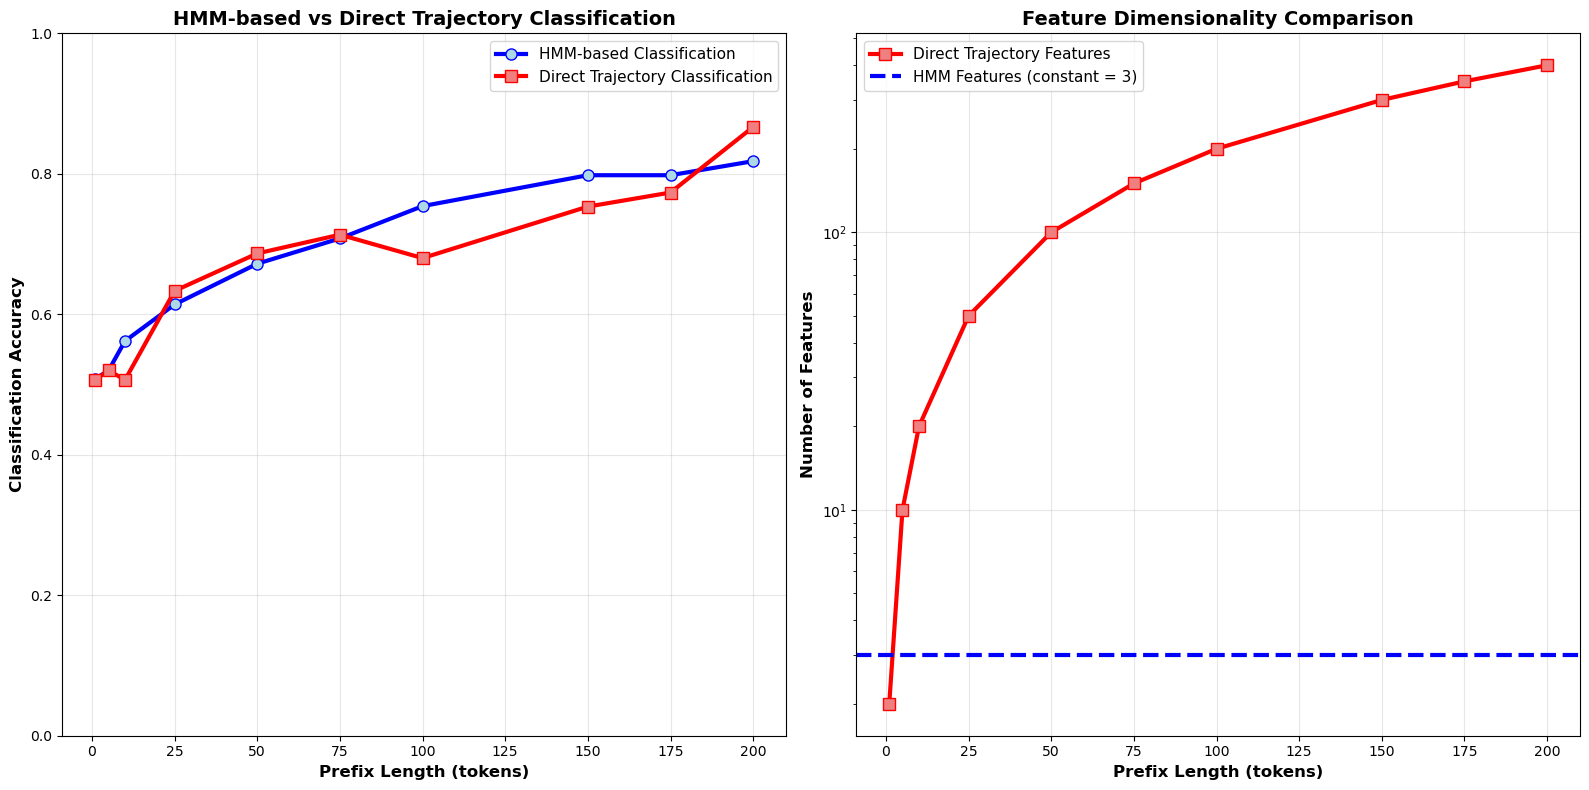

In [11]:

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

if 'test_trajectories_bb_truth' in locals() and test_trajectories_bb_truth:
    print("="*80)
    print("DIRECT TRAJECTORY-BASED CLASSIFICATION ANALYSIS")
    print("Training MLP directly on raw probability trajectories (No HMM features)")
    print("="*80)
 
    K_PREFIX_VALUES_DIRECT = [1,5,10,25,50,75,100,150,175,200]
    direct_prefix_results = {}
    
   
    
    print(f"\nTotal available test trajectories: {len(test_trajectories_bb_truth)}")
    
    for k_prefix in K_PREFIX_VALUES_DIRECT:
        print(f"\n{'='*60}")
        print(f"DIRECT TRAJECTORY CLASSIFICATION - PREFIX LENGTH: {k_prefix}")
        print(f"{'='*60}")
        
   
        X_direct = []
        y_direct = []
        
        for seq in test_trajectories_bb_truth:
            if seq.shape[0] >= k_prefix:
           
                prefix_features = seq[:k_prefix].flatten()  
              
                true_final_prob = seq[-1, TARGET_SENTIMENT]
                true_label = 1 if true_final_prob >= 0.5 else 0
                
                X_direct.append(prefix_features)
                y_direct.append(true_label)
        
        if len(X_direct) < 20:  
            print(f"   Insufficient data for k_prefix={k_prefix} (only {len(X_direct)} samples)")
            continue
            
        X_direct = np.array(X_direct)
        y_direct = np.array(y_direct)
        
        print(f"   Extracted {X_direct.shape[0]} samples with {X_direct.shape[1]} features each")
        print(f"   Feature vector shape per sample: {k_prefix} steps × {seq.shape[1]} prob dimensions = {X_direct.shape[1]} total features")
        
        # Check class balance
        pos_count = np.sum(y_direct)
        neg_count = len(y_direct) - pos_count
        print(f"   Class distribution: {pos_count} positive, {neg_count} negative")
        
       
        try:
            X_train_direct, X_test_direct, y_train_direct, y_test_direct = train_test_split(
                X_direct, y_direct, 
                test_size=0.3, 
                random_state=2,  
                stratify=y_direct if np.unique(y_direct).size > 1 else None
            )
        except ValueError as e:
            print(f"   Error in train/test split: {e}")
            continue
        
     
        scaler_direct = StandardScaler()
        X_train_scaled = scaler_direct.fit_transform(X_train_direct)
        X_test_scaled = scaler_direct.transform(X_test_direct)
        
        
        mlp_direct = MLPClassifier(
            hidden_layer_sizes=( 64, 32),  
            activation='relu',
            solver='adam',
            alpha=0.01,
            random_state=2,
            max_iter=300,
            early_stopping=True,
            validation_fraction=0.1,
            n_iter_no_change=15
        )
        
        print(f"   Training MLP on {X_train_scaled.shape[0]} training samples...")
        try:
            mlp_direct.fit(X_train_scaled, y_train_direct)
            
            
            y_pred_direct = mlp_direct.predict(X_test_scaled)
            y_pred_proba_direct = mlp_direct.predict_proba(X_test_scaled)
            
          
            accuracy = accuracy_score(y_test_direct, y_pred_direct)
            precision = precision_score(y_test_direct, y_pred_direct, zero_division=0)
            recall = recall_score(y_test_direct, y_pred_direct, zero_division=0)
            f1 = f1_score(y_test_direct, y_pred_direct, zero_division=0)
            
      
            confidences = [y_pred_proba_direct[i, y_pred_direct[i]] for i in range(len(y_pred_direct))]
            avg_confidence = np.mean(confidences)
            
    
            direct_prefix_results[k_prefix] = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'avg_confidence': avg_confidence,
                'total_test_samples': len(y_test_direct),
                'training_samples': len(y_train_direct),
                'feature_dimension': X_direct.shape[1]
            }
            
            print(f"   RESULTS:")
            print(f"     - Accuracy:    {accuracy:.4f}")
            print(f"     - Precision:   {precision:.4f}")
            print(f"     - Recall:      {recall:.4f}")
            print(f"     - F1-Score:    {f1:.4f}")
            print(f"     - Avg Confidence: {avg_confidence:.4f}")
            print(f"     - Test samples: {len(y_test_direct)}")
            
        except Exception as e:
            print(f"   Error training MLP: {e}")
            continue
    
    
    if direct_prefix_results:
        print(f"\n{'='*80}")
        print("DIRECT TRAJECTORY CLASSIFICATION SUMMARY")
        print(f"{'='*80}")
        
        print(f"{'Prefix':<8} {'Accuracy':<10} {'Precision':<11} {'Recall':<8} {'F1':<8} {'Confidence':<11} {'Test Samples':<12} {'Features':<10}")
        print("-" * 95)
        
        best_direct_accuracy = 0
        best_direct_k = None
        
        for k in sorted(direct_prefix_results.keys()):
            results = direct_prefix_results[k]
            print(f"{k:<8} {results['accuracy']:<10.4f} {results['precision']:<11.4f} {results['recall']:<8.4f} "
                  f"{results['f1']:<8.4f} {results['avg_confidence']:<11.4f} {results['total_test_samples']:<12} {results['feature_dimension']:<10}")
            
            if results['accuracy'] > best_direct_accuracy:
                best_direct_accuracy = results['accuracy']
                best_direct_k = k
        
        print(f"\nBest Direct Trajectory Performance: k={best_direct_k}, accuracy={best_direct_accuracy:.4f}")
        
    
        if 'prefix_results' in locals() and prefix_results:
            print(f"\n{'='*80}")
            print("COMPARISON: HMM-BASED vs DIRECT TRAJECTORY CLASSIFICATION")
            print(f"{'='*80}")
            
            print(f"{'Prefix':<8} {'HMM Accuracy':<13} {'Direct Accuracy':<16} {'Difference':<12} {'Winner':<10}")
            print("-" * 70)
            
            common_k_values = set(prefix_results.keys()) & set(direct_prefix_results.keys())
            hmm_wins = 0
            direct_wins = 0
            
            for k in sorted(common_k_values):
                hmm_acc = prefix_results[k]['accuracy']
                direct_acc = direct_prefix_results[k]['accuracy']
                diff = direct_acc - hmm_acc
                winner = "Direct" if diff > 0 else "HMM" if diff < 0 else "Tie"
                
                if diff > 0:
                    direct_wins += 1
                elif diff < 0:
                    hmm_wins += 1
                
                print(f"{k:<8} {hmm_acc:<13.4f} {direct_acc:<16.4f} {diff:<+12.4f} {winner:<10}")
            
            print(f"\nOverall Comparison:")
            print(f"  • HMM-based approach wins: {hmm_wins}/{len(common_k_values)} prefix lengths")
            print(f"  • Direct trajectory approach wins: {direct_wins}/{len(common_k_values)} prefix lengths")
            
            # Find best overall performers
            best_hmm_k = max(prefix_results.keys(), key=lambda k: prefix_results[k]['accuracy'])
            best_hmm_acc = prefix_results[best_hmm_k]['accuracy']
            
            print(f"\nBest Overall Performance:")
            print(f"  • HMM-based:       k={best_hmm_k}, accuracy={best_hmm_acc:.4f}")
            print(f"  • Direct trajectory: k={best_direct_k}, accuracy={best_direct_accuracy:.4f}")
            
            if best_direct_accuracy > best_hmm_acc:
                print(f"   Winner: Direct trajectory approach (+{best_direct_accuracy - best_hmm_acc:.4f})")
            elif best_hmm_acc > best_direct_accuracy:
                print(f"   Winner: HMM-based approach (+{best_hmm_acc - best_direct_accuracy:.4f})")
            else:
                print(f"   Tie between approaches")
                
        if 'prefix_results' in locals() and prefix_results:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
            
            # Plot accuracy comparison
            common_k_values = sorted(set(prefix_results.keys()) & set(direct_prefix_results.keys()))
            hmm_accuracies = [prefix_results[k]['accuracy'] for k in common_k_values]
            direct_accuracies = [direct_prefix_results[k]['accuracy'] for k in common_k_values]
            
            ax1.plot(common_k_values, hmm_accuracies, 'b-o', linewidth=3, markersize=8, 
                     label='HMM-based Classification', markerfacecolor='lightblue')
            ax1.plot(common_k_values, direct_accuracies, 'r-s', linewidth=3, markersize=8, 
                     label='Direct Trajectory Classification', markerfacecolor='lightcoral')
            
            ax1.set_xlabel('Prefix Length (tokens)', fontsize=12, fontweight='bold')
            ax1.set_ylabel('Classification Accuracy', fontsize=12, fontweight='bold')
            ax1.set_title('HMM-based vs Direct Trajectory Classification', fontsize=14, fontweight='bold')
            ax1.legend(fontsize=11)
            ax1.grid(True, alpha=0.3)
            ax1.set_ylim([0, 1])
            
            direct_feature_dims = [direct_prefix_results[k]['feature_dimension'] for k in common_k_values]
            hmm_feature_dims = [pipeline_surrogate.n_states] * len(common_k_values)  # HMM uses state posteriors
            
            ax2.plot(common_k_values, direct_feature_dims, 'r-s', linewidth=3, markersize=8, 
                     label='Direct Trajectory Features', markerfacecolor='lightcoral')
            ax2.axhline(y=hmm_feature_dims[0], color='blue', linestyle='--', linewidth=3, 
                       label=f'HMM Features (constant = {hmm_feature_dims[0]})')
            
            ax2.set_xlabel('Prefix Length (tokens)', fontsize=12, fontweight='bold')
            ax2.set_ylabel('Number of Features', fontsize=12, fontweight='bold')
            ax2.set_title('Feature Dimensionality Comparison', fontsize=14, fontweight='bold')
            ax2.legend(fontsize=11)
            ax2.grid(True, alpha=0.3)
            ax2.set_yscale('log')  
            
            plt.tight_layout()
            plt.show()
            
    else:
        print("No direct trajectory classification results available.")
        
else:
    print("No test trajectories available for direct classification analysis.")